In [1]:
import initialconditions as ic
import matplotlib.pyplot as plt

import main as main
import sys
sys.path.append("/home/s2250115/petsc/arch-linux-c-debug/lib")

import animators as ani

In [ ]:
# Define the parameters of the system
N = 1225 #Number of seeds
box = [0, 0, 1, 1] #list or tuple defining domain [xmin, ymin, xmax, ymax]
per_tol = 1e-3 #Percent tolerance
periodic_x = False # Set the periodicity of X
periodic_y = False # Set the periodicity of Y
tf = 1 #Final time
Ndt = 100 #Number of timesteps

#Initialize initial condition
Z = ic.create_initial(N, -4, -4, 4, 4, 'lattice') 

#Plot the initial condition

fig = plt.figure()
fig.set_size_inches(10, 10, True)
ax = fig.add_subplot()
ax.scatter(Z[:,0], Z[:,1], c = Z[:,0], cmap = 'jet', edgecolor = 'none', s = 8)
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

In [ ]:
main.SGSolver(box, Z, N, per_tol, tf, Ndt, periodic_x, periodic_y) #Solve and save the solution

In [ ]:
ani.point_animator('./SG_data.npz', 'C', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' 
ani.point_animator('./SG_data.npz', 'Z', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' 
ani.cell_animator('./SG_data.npz', box)

In [2]:
from pysdot.domain_types import ConvexPolyhedraAssembly
from pysdot import OptimalTransport
from pysdot import PowerDiagram
import numpy as np
import pyvista as pv
import weightguess as wg

nb_diracs = 1000

positions = np.random.rand( nb_diracs, 2 )

domain = ConvexPolyhedraAssembly()
domain.add_box([-1, -1], [2, 2])
print(domain.measure())

masses = np.ones( nb_diracs ) / nb_diracs
#masses = domain.measure() / nb_diracs * np.ones(nb_diracs)
print(sum(masses))

#w0 = wg.Rescale_weights([-1, -1, 2, 2], positions, 0*np.ones( nb_diracs), False, False)[0]
err_tol = ( 1e-3 / 100 ) * (1 / nb_diracs) 

# we have to specify that dirac masses because by default, sdot takes ones * measure( domain ) / nb_diracs
# and that's not what we want in this case
ot = OptimalTransport( positions, domain = domain, masses=masses) #, weights = w0)
ot.set_stopping_criterion(err_tol, 'max delta masses') #Pick the stopping criterion to be the mass of the cells

# first arg of add_replication is a translation
for x in [ -1, 0, 1 ]:
    for y in [ -1, 0, 1]:
        if x or y:
            ot.pd.add_replication( [ x, y] )

#ot.adjust_weights()

filename = 'pb.vtk'
ot.display_vtk( 'pb.vtk' )

9.0
1.0000000000000007


0.9999999999999994


/home/s2250115/.local/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


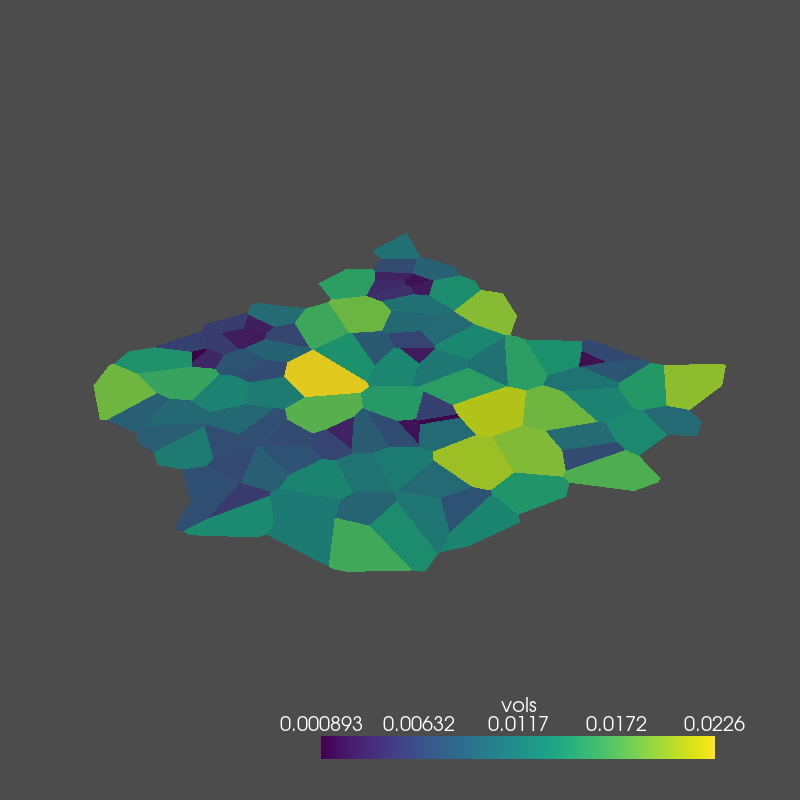

In [3]:
# Mass of cells
pd=PowerDiagram(positions=positions,weights=ot.get_weights(),domain=domain)
vols=pd.integrals()
print(sum(vols))

# Read the data
grid=pv.read(filename)

# create cell data that gives the cell volumes, this allows us to colour by cell volumes
cell_vols = vols[grid.cell_data['num'].astype(int)]
grid.cell_data['vols']=cell_vols

# plot the data with an automatically created plotter, for a static picture use backend='static'
plotter = pv.Plotter(window_size=[800,800], notebook = True, off_screen=False)
plotter.add_mesh(grid)

# Render the frame
plotter.show()

In [ ]:
for x in [ -1, 0, 1 ]:
    for y in [ -1, 0, 1 ]:
        for z in [ -1, 0, 1]:
            if x or y or z:
                print(x, y, z)